In [1]:
# -- coding: utf-8 --
# This code is part of Qiskit.
#
# (C) Copyright IBM 2019.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.
#
# Code adapted from QizGloria team, Qiskit Camp Europe 2019
# Updated by Team Ube Pancake, Qiskit Summer Jam 2020
# Version curated by Catherine Liang and Eddy Lin for Qiskit Advocate Demo, Dec 2020

# Simple Hybrid Quantum-Classical Neural Networks
### Qiskit Advocate Demo 3 Dec 2020
**Presented by Catherine Liang and Eddy Lin**

In this extension of the hybrid quantum-classical neural network [article in the Qiskit Textbook](https://qiskit.org/textbook/ch-machine-learning/machine-learning-qiskit-pytorch.html), we demonstrate the ability to use quantum circuits (built with Qiskit) to interface with neural networks (using Pytorch) to perform a simple classification task. Then, we expand this architecture to do different tasks, such as to build a denoising autoencoder.

### Contents

- Construct the quantum circuit
- Implement circuit as layer in Pytorch
- Load MNIST data
- Build our neural network
- Run classification on MNIST data (0-1)
- Make denoising autoencoder for MNIST data (0-1)

Let's get started!

#### Import packages

In [2]:
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms

from qiskit import execute
from qiskit.circuit import Parameter,QuantumCircuit
from qiskit import Aer
import qiskit

import numpy as np

from tqdm import tqdm

import itertools

from matplotlib import pyplot as plt
%matplotlib inline

#### Set Hyperparameters

Here, we need to define some hyperparameters that will be used in the quantum circuit and architecture for the neural network in Pytorch.

In [3]:
np.random.seed = 42

NUM_QUBITS = 2
NUM_CIRCUITS = 3
NUM_SHOTS = 10000
SHIFT = 0.9
LEARNING_RATE = 0.01
MOMENTUM = 0.5 # if using optimizer with momentum
SIMULATOR = Aer.get_backend('qasm_simulator')

### Contruct the QuantumCircuit Class

Here, we create a simple quantum circuit with `NUM_CIRCUITS` number of qubits (2, in our case) that has 2 gate rotation parameters and 2 outputs.

In [4]:
def to_numbers(tensor_list):
    num_list = []
    for tensor in tensor_list:
        num_list += [tensor.item()]
    return num_list

class QiskitCircuit():
    def __init__(self, n_qubits, backend, shots):
        self.beta = Parameter('Beta')
        self.gamma = Parameter('Gamma')
        self.shots = shots
        
        def create_circuit():
            ckt = QuantumCircuit(2, 2)
            # add mixer part
            ckt.rx(self.beta, 0)
            ckt.rx(self.beta, 1)

            # add H_target part, for each Zi Zj do this
            ckt.cx(0,1)
            ckt.rz(-1*self.gamma, 1)
            ckt.cx(0,1)
            ckt.measure([0,1],[0,1])
            return ckt

        self.circuit = create_circuit()
    
    def energy_expectation(self, counts, shots, i,j, Cij=-1): #calculate expectation for one qubit pair
        expects = 0
        for key in counts.keys():
            perc = counts[key]/shots
            check = Cij*(float(key[i])-1/2)*(float(key[j])-1/2)*perc
            expects += check   
            
        return [expects] 
    
    def bind(self,parameters):
        [self.beta,self.gamma] = parameters
        self.circuit.data[0][0]._params = to_numbers(parameters)[0:1]
        self.circuit.data[1][0]._params = to_numbers(parameters)[0:1]
        self.circuit.data[3][0]._params = to_numbers(parameters)[1:2]
        
        return self.circuit
 
    def run(self, i):
        self.bind(i)
        backend = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit,backend,shots=self.shots)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        
        return self.energy_expectation(counts, self.shots, 0,1)   

Expected value for rotation [pi/4]: [-0.12340000000000001]


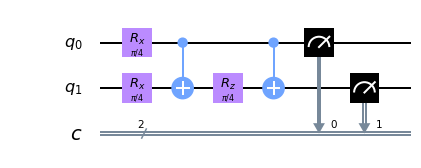

In [5]:
circuit = QiskitCircuit(NUM_QUBITS, SIMULATOR, NUM_SHOTS)
print('Expected value for rotation [pi/4]: {}'.format(circuit.run(torch.Tensor([np.pi/4]*NUM_QUBITS))))
circuit.circuit.draw(output='mpl')

### Implement circuit as layer in Pytorch (TorchCircuit)

Each layer in Pytorch has two basic functions: `forward` and `backward`. The first performs the layer's forward pass through the network, and the backward calculates the gradient (using a finite difference), which is used to update the previous layers' parameters.

In [6]:
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)
        
        exp_value = ctx.QiskitCirc.run(i)
        result = torch.tensor([exp_value])
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        forward_tensor, i = ctx.saved_tensors
        input_numbers = i
        gradients = torch.Tensor()
        
        for k in range(NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT

            expectation_right = ctx.QiskitCirc.run(shift_right)
            expectation_left  = ctx.QiskitCirc.run(shift_left)
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])*2
            gradients = torch.cat((gradients, gradient.float()))
            
        result = torch.Tensor(gradients)

        return (result.float() * grad_output.float()).T

#### Test the Quantum Circuit's Gradient Descent

Using a toy example to test the gradient descent, we want the "neural net" consisting of just the quantum circuit and a linear layer to converge to an optimal set of parameters. If the gradient descent works, we should see that the loss eventually goes down.

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.77it/s]


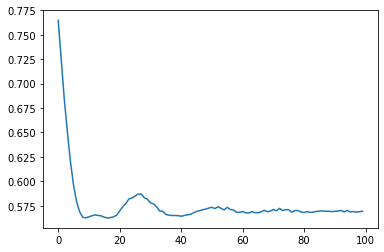

In [7]:
qc = TorchCircuit.apply

def cost(x):
    target = -1
    expval = qc(x)[0]
    val = expval
    
    return torch.abs(val - target) ** 2, expval

x = torch.tensor([-np.pi/4]*NUM_QUBITS, requires_grad=True)
opt = torch.optim.Adam([x], lr=0.1)

num_epoch = 100

loss_list = []
expval_list = []

for i in tqdm(range(num_epoch)):
    opt.zero_grad()
    loss, expval = cost(x)
    loss.backward()
    opt.step()
    loss_list.append(loss.item())
    expval_list.append(expval)

plt.plot(loss_list)

### Load MNIST (0-1) Data

We will now load 200 samples of each class (0 and 1) from MNIST to use as training data and the same amounts for the testing data.

**Training Data**

In [8]:
n_samples = 200

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True, pin_memory=True)

**Testing Data**

In [21]:
n_samples = 200

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

### Build our neural network with the quantum layer

Now, the fun part! Using the TorchCircuit we just created, we can define the structure of the NN. The overall structure consists of convolutional layers, linear layers, the quantum layer, and an output linear layer.

In [10]:
NUM_CIRCUITS = 3

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, NUM_QUBITS*NUM_CIRCUITS*2)
        self.fake_qc = nn.Linear(NUM_QUBITS, NUM_CIRCUITS)
        self.qc = TorchCircuit.apply
        self.out = nn.Linear(NUM_CIRCUITS, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        x = torch.tanh(x) # rescale to [-1, 1] to get sin(theta), cos(theta) for each angle
        x = x.view(-1) # flatten to 1D tensor
        x = torch.cat([(x[i * 2 : i*2 + 2]) / torch.norm(x[i * 2: i*2 + 2]) 
                       for i in range(NUM_CIRCUITS*2)], dim=-1) # normalize sin and cos for each angle
        x = torch.stack([torch.atan2(x[i * 2], x[i*2 + 1]) for i in range(NUM_CIRCUITS*2)]) # convert to angles
        x = torch.cat([qc(x[i * 2 : i*2 + 2]) for i in range(NUM_CIRCUITS)], dim=1) # QUANTUM LAYER

        x = self.out(x)
        return F.log_softmax(x)

    def predict(self, x):
        # apply softmax
        pred = self.forward(x)
        ans = torch.argmax(pred[0]).item()
        return torch.tensor(ans)
    
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01,
                      momentum=0.6)

#### Run training with 5 epochs

In [12]:
epochs = 5
loss_list = []
loss_func = F.nll_loss

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(tqdm(train_loader, position=0, leave=True)):
        optimizer.zero_grad()        
        # Forward pass
        output = network(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
        
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

Training [20%]	Loss: 0.6355


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

Training [40%]	Loss: 0.5036


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

Training [60%]	Loss: 0.4035


  0%|                                                                                          | 0/400 [00:00<?, ?it/s]

Training [80%]	Loss: 0.3373


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [02:07<00:00,  3.13it/s]

Training [100%]	Loss: 0.2882


Text(0, 0.5, 'Cross Entropy Loss')

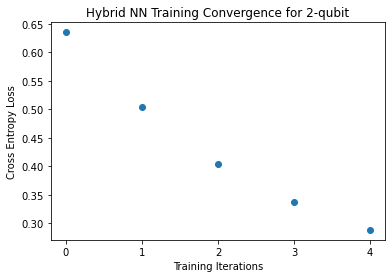

In [13]:
plt.plot(loss_list, 'o')
plt.xticks(range(epochs))
plt.title('Hybrid NN Training Convergence for {}-qubit'.format(NUM_QUBITS))
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')

#### Calculate test accuracy

In [23]:
accuracy = 0
number = 0
for batch_idx, (data, target) in enumerate(tqdm(test_loader, position=0, leave=True)):
    number +=1
    output = network.predict(data).item()
    accuracy += (output == target[0].item())*1

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:26<00:00, 14.97it/s]


In [27]:
print("Performance on test data: {}/{} = {}%".format(accuracy,number,100*accuracy/number))    

Performance on test data: 400/400 = 100.0%


#### View some sample predictions

C:\Users\Edward\anaconda3\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


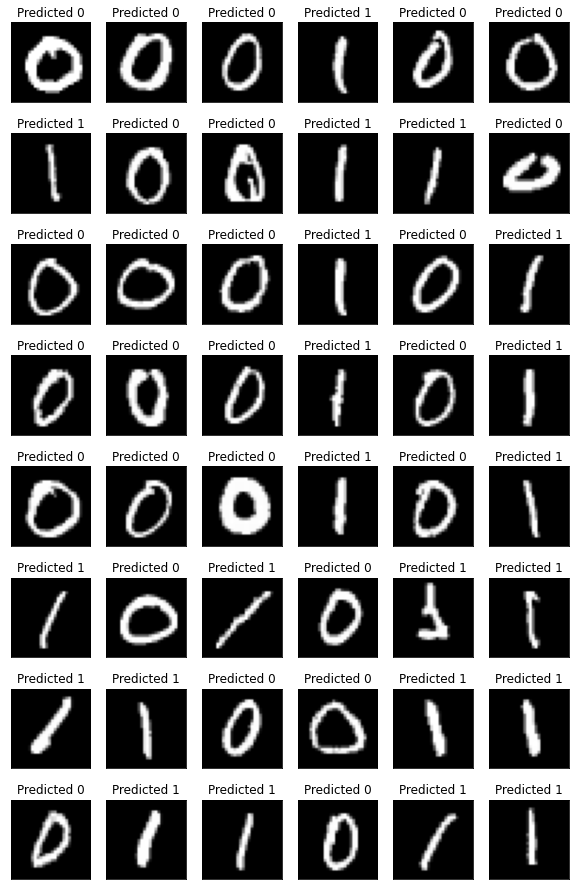

In [26]:
n_samples_shape = (8, 6)
count = 0
fig, axes = plt.subplots(nrows=n_samples_shape[0], ncols=n_samples_shape[1], figsize=(10, 2*n_samples_shape[0]))

network.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_shape[0]*n_samples_shape[1]:
            break
        pred = network.predict(data).item()

        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].set_xticks([])
        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].set_yticks([])
        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].set_title('Predicted {}'.format(pred))
        
        count += 1

### Discussion Questions

1. What are some ways to speed up the runtime of the training and testing?
2. How could we increase the size of the quantum layer (ie. more inputs and more outputs) to extend these results to harder problems?

## Build the quantum denoising autoencoder

Now, we will begin constructing our denoising autoencoder. The denoising autoencoder serves two purposes: first, it learns to *encode*, or to find an efficient representation (ie. a vector of numbers) of, an image and to reconstruct the original image from this smaller representation. Second, it learns to encode noisy images, so that the reconstruction returns the same input image without the noise.

#### Load the MNIST 0-1 data (again)

This time, we use more training images (500) for each class, since our denoising autoencoder needs more data to train well.

**Training data**

In [28]:
n_samples = 500

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]


train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True, pin_memory=True)

**Testing Data**

In [29]:
n_samples = 200

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][n_samples:], 
                np.where(X_test.targets == 1)[0][n_samples:])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [31]:
import torch.nn as nnleaky_relu
import torch.nn.functional as F

NUM_CIRCUITS=5

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()

        n_filters = 32
        ## encoder layers ##
        self.conv1 = nn.Conv2d(1, n_filters, 3, padding=1)
        self.conv2 = nn.Conv2d(n_filters, 4, 3, padding=1)
        self.conv3 = nn.Conv2d(4, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc2 = nn.Linear(36, NUM_QUBITS*NUM_CIRCUITS*2)
        self.fake_qc = nn.Linear(NUM_QUBITS*NUM_CIRCUITS*2, NUM_CIRCUITS)
        
        self.qc = TorchCircuit.apply
        self.out = nn.Linear(NUM_CIRCUITS, 36)

        ## decoder layers ##
        self.t_conv0 = nn.ConvTranspose2d(4, 4, 3, stride=2)
        self.t_conv1 = nn.ConvTranspose2d(4, n_filters, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(n_filters, 1, 2, stride=2)

    def forward(self, x):
        ## encode ##
        x = F.leaky_relu(self.conv1(x))
        x = self.pool(x)
        x = F.leaky_relu(self.conv2(x))
        x = self.pool(x)
        x = F.leaky_relu(self.conv3(x))
        x = self.pool(x)
        x = nn.Flatten()(x)
        ## quantum ##
        
        x = self.fc2(x)
        
#         x = self.fake_qc(x)
        
        x = torch.tanh(x) # rescale to [-1, 1] to get sin(theta), cos(theta) for each angle
        x = x.view(-1) # flatten to 1D tensor
        x = torch.cat([(x[i * 2 : i*2 + 2]) / torch.norm(x[i * 2: i*2 + 2]) 
                       for i in range(NUM_CIRCUITS*2)], dim=-1) # normalize sin and cos for each angle
        x = torch.stack([torch.atan2(x[i * 2], x[i*2 + 1]) for i in range(NUM_CIRCUITS*2)]) # convert to angles
        x = torch.cat([qc(x[i * 2 : i*2 + 2]) for i in range(NUM_CIRCUITS)], dim=1) # QUANTUM LAYER

        x = self.out(x)
        x = x.view(-1, 4, 3, 3)
        
        ## decode ##
        x = F.leaky_relu(self.t_conv0(x))        
        x = F.leaky_relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))
       
        return x

# initialize the NN
model = ConvDenoiser()
print(model)

ConvDenoiser(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=36, out_features=20, bias=True)
  (fake_qc): Linear(in_features=20, out_features=5, bias=True)
  (out): Linear(in_features=5, out_features=36, bias=True)
  (t_conv0): ConvTranspose2d(4, 4, kernel_size=(3, 3), stride=(2, 2))
  (t_conv1): ConvTranspose2d(4, 32, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
)


In [32]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def add_gaussian_noise(images, sigma=0.5):
    return torch.clamp(torch.distributions.Normal(0, sigma).sample(images.shape) + images, 0., 1.)

from tqdm import tqdm

# number of epochs to train the model
n_epochs = 5

# for adding noise to images

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in tqdm(train_loader, position=0, leave=True):
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        
        ## add random noise to the input images TODO
        noisy_imgs = add_gaussian_noise(images)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs)
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\Edward\anaconda3\lib\site-packages\torch\nn\functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.086526


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.058183


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.050178


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.046356


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:47<00:00,  1.90it/s]

Epoch: 5 	Training Loss: 0.044133


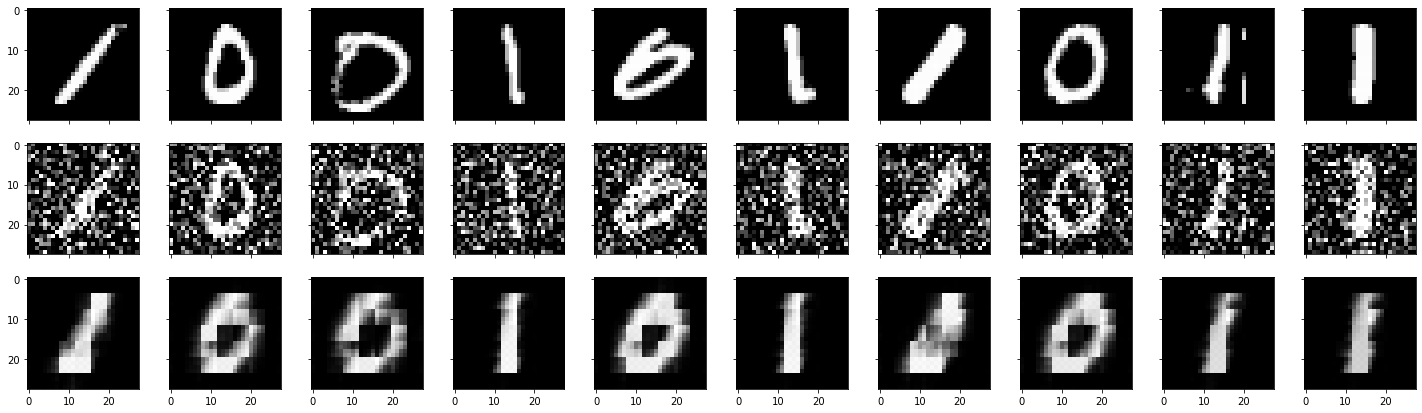

In [35]:
# plot the first ten input images and then reconstructed images
ncols = 10
fig, axes = plt.subplots(nrows=3, ncols=ncols, sharex=True, sharey=True, figsize=(25,7))
    
for k in range(ncols):
    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, labels = dataiter.next()

    # add noise to the test images TODO
    noisy_imgs = add_gaussian_noise(images)

    # get sample outputs
    output = model(noisy_imgs)
    # prep images for display
    noisy_imgs = noisy_imgs.numpy()

    # output is resized into a batch of iages
    output = output.view(1, 1, 28, 28)
    # use detach when it's an output that requires_grad
    output = output.detach().numpy()

    col_axes = axes[:, k]
    
    col_axes[0].imshow(np.squeeze(images), cmap='gray')
    col_axes[1].imshow(np.squeeze(noisy_imgs), cmap='gray')
    col_axes[2].imshow(np.squeeze(output), cmap='gray') 

### Discussion Questions

1. What do you notice from these results? How well do the reconstructions get to approximating the ground truth images (top row)? How good is the denoising?
2. Why might the variation between denoised reconstructions be low (ie. many of the reconstructions look similar to each other?)